In [1]:
import sys
sys.path.append('../')

import numpy as np

from ForwardModeling.ForwardProcessing1D import forward_with_trace_calcing
from Inversion.Strategies.SeismDiffInversion1D import inverse
from Inversion.Optimizators.Optimizations import LBFGSBOptimization, DifferentialEvolution, TrustKrylov, TrustConstr, \
    ConjugateGradient
from Tests.test_ForwardProcessing1D import get_model_2layered, get_model_3layered
from Data.geol_models import get_model_3layered_fluid
from Objects.Data.WavePlaceholder import OWT, WaveDataPlaceholder
from Objects.Models.Models import SeismicModel1D
from Objects.Attributes.RockPhysics.RockPhysicsAttribute import RockPhysicsAttribute
from Objects.Models.Layer1D import Layer1D, LayerOPT
import time

from matplotlib import pyplot as plt
from Inversion.Strategies.SeismDiffInversion1D import func_to_optimize

In [3]:
def plot_1D_err(forward_params, nvals, min_max=None, dot=False, vline_x=None):
    
    if min_max is None:
        min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
        max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
        
    else:
        min_val = np.array([min_max[0]])
        max_val = np.array([min_max[1]])
    
    dval = (max_val - min_val) / nvals

    val_x = [min_val + dval*i for i in range(nvals+1)]
    errs = []
    for val in val_x:
        errs.append(func_to_optimize(val, placeholders, forward_params, helper=None, show_tol=False))
        
    plt.plot(val_x, errs)
    if dot:
        plt.plot(val_x, errs, 'o')
        
    if vline_x is not None:
        plt.vlines(vline_x, ymin=min(errs), ymax=max(errs), colors='r')
        
    plt.show()

def optimization_func_2D(forward_params, x, y):
    indexes_1 = np.arange(x.shape[0])
    indexes_2 = np.arange(x.shape[1])
    
    Z = np.zeros((x.shape[0], x.shape[1]))
    
    for ind1 in indexes_1:
        for ind2 in indexes_2:
            Z[ind1, ind2] = func_to_optimize([x[ind1, ind2], y[ind1, ind2]], placeholders, forward_params, helper=None, show_tol=False)
        
    return Z

def plot_2D_err(forward_params, nvals, ncontous=10, points=None):
    min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
    max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
    
    dval = (max_val - min_val) / nvals

    val_1_x = [min_val[0] + dval[0]*i for i in range(nvals[0]+1)]
    val_2_x = [min_val[1] + dval[1]*i for i in range(nvals[1]+1)]

    X, Y = np.meshgrid(val_1_x, val_2_x)

    Z = optimization_func_2D(forward_params, X, Y)
    
    plt.contourf(X, Y, Z, ncontous, cmap='seismic')
    plt.colorbar()
    
    if points is not None:
        plt.plot(points[0], points[1], marker='x', color='r')

# 2-layered model

In [10]:
layer_1 = Layer1D(h,
                  rp_attribute=RockPhysicsAttribute(layer_1_dict["components"], layer_1_dict["name"]),
                  seism_attribute=None,
                  opt=LayerOPT.RP)

layer_2 = Layer1D(-1,
                  rp_attribute=RockPhysicsAttribute(layer_2_dict["components"], layer_2_dict["name"]),
                  seism_attribute=None,
                  opt=LayerOPT.RP)

In [11]:
dx = 100
nx = 20
x_rec = [i * dx for i in range(1, nx)]
wave_types = [OWT.PdPu]

In [12]:
model = SeismicModel1D([layer_1, layer_2])
model_true = SeismicModel1D([layer_1, layer_2])
model_opt = SeismicModel1D([layer_1, layer_2])

In [13]:
observe, test_seismic = \
    forward_with_trace_calcing(model, x_rec,
                               dt=3e-03, trace_len=1500, wavetypes=wave_types, display_stat=True,
        visualize_res=False)

Calculating rockphysics model...
Rockphysics model calculated!
Calculating PdPu-rays...
Calculating PdPu-reflections...
Calculating p-refractions...


In [14]:
forward_params = {
    "model": model,
    "x_rec": x_rec,
    "dt": 3e-03,
    "trace_len": 1500,
    "wavetypes": wave_types,
    "display_stat": False,
    "visualize_res": False
}

In [10]:
placeholders = {}
for wt in wave_types:
    placeholders[wt] = WaveDataPlaceholder(
        wt,
        test_seismic[wt]["rays"],
        test_seismic[wt]["seismogram"]
    )

In [21]:
optimizers = [
    LBFGSBOptimization(
        maxiter=15000,
        maxfun=15000,
        factr=10000,
        maxls=50,
        epsilon=0.000001
    )
]

In [132]:
optimizers = [
    DifferentialEvolution()
]

In [133]:
forward_params['model'].layers[0]['Km'] = 10

In [134]:
forward_params['model'].layers[1]['Km'] = 25

In [135]:
forward_params['model'].layers[0].rp_attribute.vals_dict['Km']["optimize"] = True

In [136]:
forward_params['model'].layers[1].rp_attribute.vals_dict['Km']["optimize"] = True

In [139]:
inversed_model = inverse(optimizers, error=0.01, placeholders=placeholders, forward_params=forward_params)

0.28963981555513735
0.24318202245426948
0.3036591384718607
0.2681994770851526
0.3158887885125874
0.11733143944421526
0.23793330149363667
0.1928839756728753
0.3190887519398826
0.22500372786123748
0.24119477271271672
0.23933181656513197
0.20139060678181012
0.2170747273431636
0.05231358982842281
0.2039342095252275
0.06495235257187576
0.28911024162799975
0.14736149433550547
0.04847486972811233
0.32747266041135775
0.22567450699539163
0.1897540988256148
0.29991395966586487
0.16389648856082809
0.2046265374964593
0.3453497955095944
0.34798394179843034
0.30995865653319915
0.23070859734782234
0.3554557834285149
0.09506400783975795
0.19379078437235014
0.2692708845884677
0.3373489632757625
0.2479217271179494
0.2365875651460144
0.28514604481474237
0.23422753430183002
0.35055564728627425
0.21292978534022688
0.11371672695670602
0.04699641873161136
0.2235219582602103
0.23899108129730584
0.15485987233380266
0.18928561374821
0.369617913270291
0.2273681507180174
0.21342626667854356
0.30853361416511155
0.

In [140]:
inversed_model

array([ 7.31822513, 21.18522283])

## Single variable opt

In [111]:
from Inversion.Strategies.SeismDiffInversion1D import func_to_optimize

In [112]:
forward_params['model'].layers[0].rp_attribute.vals_dict['Km']["optimize"] = False

In [113]:
forward_params['model'].layers[1].rp_attribute.vals_dict['Km']["optimize"] = True

In [114]:
forward_params['model'].layers[0]['Km'] = 7.3

In [104]:
forward_params['model'].layers[1]['Km'] = 21.5

In [105]:
forward_params['model'].get_optimization_option("val", vectorize=True)

array([21.5])

In [106]:
min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
max_val = forward_params['model'].get_optimization_option("max", vectorize=True)

In [107]:
nvals = 30

In [109]:
dval = (max_val - min_val) / nvals

val_x = [min_val + dval*i for i in range(nvals+1)]
errs = []
for val in val_x:
    errs.append(func_to_optimize(val, placeholders, forward_params, helper=None, show_tol=False))

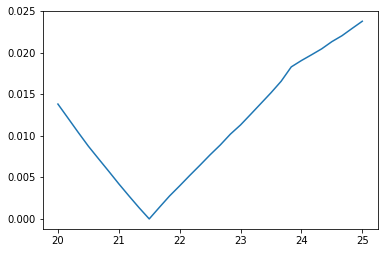

In [110]:
plt.plot(val_x, errs)

## Duo variable opt

In [7]:
forward_params['model'].layers[1].rp_attribute.vals_dict['Km']["optimize"] = True

NameError: name 'forward_params' is not defined

In [8]:
forward_params['model'].get_optimization_option("val", vectorize=True)

NameError: name 'forward_params' is not defined

In [37]:
min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
max_val = forward_params['model'].get_optimization_option("max", vectorize=True)

In [52]:
def f(x, y):
    return np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)


In [ ]:
dval = (max_val - min_val) / nvals

val_1_x = [min_val[0] + dval[0]*i for i in range(nvals[0]+1)]
val_2_x = [min_val[1] + dval[1]*i for i in range(nvals[1]+1)]

X, Y = np.meshgrid(val_1_x, val_2_x)

Z = optimization_func_2D(X, Y)

In [93]:
Z.shape

(8, 11)

In [94]:
X.shape

(8, 11)

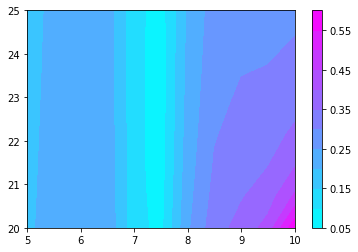

In [98]:
plt.contourf(X, Y, Z, 10, cmap='cool')
plt.colorbar()

# 3-layered model

In [4]:
h = 1000

In [18]:
layer_1_dict, layer_2_dict, layer_3_dict = get_model_3layered_fluid()

In [19]:
layer_3_1 = Layer1D(h,
                  rp_attribute=RockPhysicsAttribute(layer_1_dict["components"], layer_1_dict["name"]),
                  seism_attribute=None,
                  opt=LayerOPT.RP)

layer_3_2 = Layer1D(h,
                  rp_attribute=RockPhysicsAttribute(layer_2_dict["components"], layer_2_dict["name"]),
                  seism_attribute=None,
                  opt=LayerOPT.RP)

layer_3_3= Layer1D(-1,
                  rp_attribute=RockPhysicsAttribute(layer_3_dict["components"], layer_2_dict["name"]),
                  seism_attribute=None,
                  opt=LayerOPT.RP)

In [20]:
dx = 300
nx = 5
x_rec = [i * dx for i in range(1, nx+1)]
wave_types = [OWT.PdPu]
# wave_types = [OWT.PdPu, OWT.PdSVu]

In [21]:
model_3l = SeismicModel1D([layer_3_1, layer_3_2, layer_3_3])

In [22]:
observe, test_seismic = \
    forward_with_trace_calcing(model_3l, x_rec,
                               dt=3e-03, trace_len=1500, wavetypes=wave_types, display_stat=True,
        visualize_res=False)

Calculating rockphysics model...
Rockphysics model calculated!
Calculating PdPu-rays...
Calculating PdPu-reflections...
Calculating p-refractions...


In [23]:
forward_params = {
    "model": model_3l,
    "x_rec": x_rec,
    "dt": 3e-03,
    "trace_len": 1500,
    "wavetypes": wave_types,
    "display_stat": False,
    "visualize_res": False
}

In [24]:
placeholders = {}
for wt in wave_types:
    placeholders[wt] = WaveDataPlaceholder(
        wt,
        test_seismic[wt]["rays"],
        test_seismic[wt]["seismogram"]
    )

In [12]:
optimizers_lbfgs = [
    LBFGSBOptimization(
        maxiter=15000,
        maxfun=15000,
#         factr=10000,
#         maxls=50,
#         epsilon=0.000001
    )
]

In [13]:
optimizers_cg = [
    ConjugateGradient()
]

In [25]:
optimizers_de = [
    DifferentialEvolution(
          popsize= 5,
          maxiter= 20000,
          init= "latinhypercube",
          strategy= "best1bin",
          disp= False,
          polish= False,
          tol= 0.00001,
          mutation= 1.5,
          recombination= 0.6,
          workers= 8
    )
]

In [95]:
optimizers_tc = [
    TrustConstr(
        opt_options={
            "initial_tr_radius": 0.7,
            "maxiter": 1000000
#             "gtol":1e-4,
        }
    ),
#     LBFGSBOptimization(
#         maxiter=15000,
#         maxfun=15000,
#         factr=10000,
#         maxls=50,
#         epsilon=0.000001
#     )
]

### Km optimization

In [124]:
# opt_flag = True
opt_flag = False
if opt_flag:
    forward_params['model'].layers[0]["Km"] = 9
    forward_params['model'].layers[0].opt = LayerOPT.RP
    forward_params['model'].layers[0].rp_attribute.vals_dict['Km']['optimize'] = True
    
else:
    forward_params['model'].layers[0]["Km"] = 7.3
    forward_params['model'].layers[0].opt = LayerOPT.NO
    forward_params['model'].layers[0].rp_attribute.vals_dict['Km']['optimize'] = False

# opt_flag = True
opt_flag = False

if opt_flag:
    forward_params['model'].layers[1]["Km"] = 25
    forward_params['model'].layers[1].opt = LayerOPT.RP
    forward_params['model'].layers[1].rp_attribute.vals_dict['Km']['optimize'] = True

else:
    # TRUE VALUE
    forward_params['model'].layers[1]["Km"] = 21.5
    forward_params['model'].layers[1].opt = LayerOPT.NO
    forward_params['model'].layers[1].rp_attribute.vals_dict['Km']['optimize'] = False



# opt_flag = True
opt_flag = False

if opt_flag:
    forward_params['model'].layers[2]["Km"] = 25
    forward_params['model'].layers[2].opt = LayerOPT.RP
    forward_params['model'].layers[2].rp_attribute.vals_dict['Km']['optimize'] = True

else:
    # TRUE VALUE
    forward_params['model'].layers[2]["Km"] = 22
    forward_params['model'].layers[2].opt = LayerOPT.NO
    forward_params['model'].layers[2].rp_attribute.vals_dict['Km']['optimize'] = False



### Gm optimization

In [125]:
opt_flag = True
# opt_flag = False
if opt_flag:
    forward_params['model'].layers[0]["Gm"] = 5
    forward_params['model'].layers[0].opt = LayerOPT.RP
    forward_params['model'].layers[0].rp_attribute.vals_dict['Gm']['optimize'] = True
    
else:
    forward_params['model'].layers[0]["Gm"] = 2.71
    forward_params['model'].layers[0].opt = LayerOPT.NO
    forward_params['model'].layers[0].rp_attribute.vals_dict['Gm']['optimize'] = False

opt_flag = True
# opt_flag = False

if opt_flag:
    forward_params['model'].layers[1]["Gm"] = 15
    forward_params['model'].layers[1].opt = LayerOPT.RP
    forward_params['model'].layers[1].rp_attribute.vals_dict['Gm']['optimize'] = True

else:
    # TRUE VALUE
    forward_params['model'].layers[1]["Gm"] = 17.5
    forward_params['model'].layers[1].opt = LayerOPT.NO
    forward_params['model'].layers[1].rp_attribute.vals_dict['Gm']['optimize'] = False



# opt_flag = True
opt_flag = False

if opt_flag:
    forward_params['model'].layers[2]["Gm"] = 15
    forward_params['model'].layers[2].opt = LayerOPT.RP
    forward_params['model'].layers[2].rp_attribute.vals_dict['Gm']['optimize'] = True

else:
    # TRUE VALUE
    forward_params['model'].layers[2]["Gm"] = 10.7
    forward_params['model'].layers[2].opt = LayerOPT.NO
    forward_params['model'].layers[2].rp_attribute.vals_dict['Gm']['optimize'] = False



## Model calcing

In [97]:
# scale="minmax"
scale=None
start_time = time.time()
# optimizers_tc[0].opt_options["finite_diff_rel_step"] = 0.1
inversed_model = inverse(optimizers_tc, error=0.07, placeholders=placeholders, forward_params=forward_params, scale=scale)
print(f"TC time: {time.time() - start_time}")

0.14651545438046212
0.14651545383051245
99999
0.14570179676316672
0.14570179624073992
0.14570179806733236
0.14609867839196158
0.14609867785977537
0.14609867972614482
0.14625271260409506
0.14625271206669524
0.1462527139602024
0.14638570181809618
0.14638570127459044
0.1463857031978265
0.1464327896343362
0.14643278908780355
0.14643279102677917
0.14650170060950854
0.1465017000603845
0.1465017020119024
0.14646367071706648
0.14646367016850484
0.14646367211834005
0.14646533509444634
0.14646533454582786
0.14646533649615487
0.14646972540398567
0.14646972485504556
0.14646972680700934
0.14651325136572307
0.14651325081593744
0.14651325277142233
0.14651435263300724
0.14651435208313973
0.14651435403904217
0.14651490344667645
0.14651490289676783
0.1465149048528794
0.14651517889855006
0.14651517834862096
0.14651518030483707
0.14651531663575068
0.1465153160858113
0.14651531804207982
0.1465153855071675
0.146515384957223
0.14651538691351762
0.14651541994358003
0.14651541939363294
0.1465154213499407
0.146

0.13344803393160856
0.13344803403237349
0.13344803332935445
0.13344803393160462
0.13344803403236974
0.13344803332935035
0.13344803393160068
0.13344803403236571
0.13344803332934646
0.13344803393159682
0.13344803403236177
0.13344803332934244
0.13344803393159294
0.1334480340323577
0.1334480333293386
0.13344803393158897
0.13344803403235378
0.13344803332933475
0.133448033931585
0.13344803403235
0.13344803332933072
0.13344803393158133
0.13344803403234612
0.13344803332932675
0.1334480339315771
0.133448034032342
0.1334480333293229
0.13344803393157312
0.13344803403233826
0.13344803332931876
0.1334480339315694
0.13344803403233413
0.13344803332931515
0.13344803393156562
0.1334480340323303
0.13344803332931104
0.1334480339315614
0.13344803403232647
0.13344803332930713
0.13344803393155744
0.13344803403232247
0.13344803332930325
0.1334480339315535
0.13344803403231864
0.13344803332929922
0.13344803393154964
0.13344803403231453
0.13344803332929542
0.13344803393154592
0.13344803403231076
0.1334480333292

0.1334480339310587
0.13344803403182362
0.1334480333288043
0.13344803393105475
0.1334480340318197
0.13344803332880031
0.1334480339310509
0.1334480340318155
0.13344803332879646
0.13344803393104693
0.13344803403181166
0.13344803332879265
0.13344803393104301
0.13344803403180772
0.13344803332878877
0.13344803393103896
0.133448034031804
0.1334480333287846
0.13344803393103521
0.13344803403179994
0.1334480333287808
0.13344803393103125
0.13344803403179603
0.1334480333287768
0.13344803393102722
0.13344803403179198
0.133448033328773
0.13344803393102328
0.13344803403178845
0.13344803332876898
0.1334480339310192
0.1334480340317842
0.13344803332876484
0.13344803393101545
0.1334480340317803
0.13344803332876112
0.13344803393101146
0.1334480340317764
0.1334480333287572
0.13344803393100757
0.13344803403177252
0.13344803332875316
0.13344803393100368
0.13344803403176853
0.13344803332874922
0.13344803393099974
0.13344803403176458
0.13344803332874555
0.13344803393099575
0.13344803403176075
0.133448033328741

KeyboardInterrupt: 

In [26]:
# scale="minmax"
scale=None
start_time = time.time()
inversed_model = inverse(optimizers_de, error=0.01, placeholders=placeholders, forward_params=forward_params, scale=scale)
print(f"DE time: {time.time() - start_time}")

/home/apenkin/miniconda3/envs/rpsi/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:454: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


0.1449813485035918
0.16427586781521877
0.158561690738698
0.09258371086412504
0.10778476324956873
0.09559204935088748
0.07374015929315655
0.11471285279760163
0.1339695693930092
0.0585164695534669
0.1674553077011093
0.09167862262108703
0.09983885771503825
0.09199986171246582
0.13441743697862077
0.10286320984420155
0.09452518360608234
0.10078435321137941
0.08374165636715736
0.09501698953226516
0.14681439967506058
0.06214007458919423
0.10267118416800795
0.13628186534425005
0.10218011086796341
0.12479303281687422
0.09940349897103117
0.11734478605588869
0.06512580407180006
0.09169025082663815
0.12168405385537494
0.16920642957799012
0.13695307883927113
0.08947239846324098
0.1521154527770313
0.1503341357074486
0.09293573188579782
0.10546135822057179
0.09173372198218048
0.1056180330740095
0.09426635810827635
0.09613845921169666
0.05765310978472399
0.09231573013319594
0.06160021349124063
0.09624005972515948
0.09407088477922951
0.08175802605330865
0.15421977366473238
0.14466035836171853
0.0983426

0.06453684056605383
0.0871026951732321
0.06877098622436378
0.07228538259080472
0.10411647370477668
0.07293719011084854
0.08119213388113541
0.07087824850471826
0.06815780521361275
0.07484538891478061
0.07634307656401312
0.07673803552462334
0.0525227502497027
0.0733966596798705
0.07796323720406056
0.07532204415848343
0.06394921422224924
0.10577424366329286
0.05578860264714934
0.06418350411579014
0.07426753771112929
0.10046425228703659
0.062255857854074725
0.08454957367141404
0.07505929521713313
0.11401635525894709
0.10224111698172696
0.10236853956546932
0.088296792444528
0.058876475124653084
0.06761758858742935
0.08725364594763876
0.09579148280213101
0.059253136713084464
0.06504806866792101
0.08340410813664496
0.0649906369415236
0.07799558220200126
0.06246133387057853
0.06686949204942425
0.09004722110007729
0.08583527334470975
0.09948698699844871
0.05784126112160335
0.058646042189775434
0.06134227692831068
0.07823702007999747
0.08238521408602195
0.09353855513662446
0.0892317182928177
0.0

0.09927913544398609
0.12198582174011617
0.09610643056842058
0.05421696515032386
0.07474320047750276
0.08014512840607867
0.06576078987837503
0.0851283089636179
0.10852122412333752
0.09349126333826493
0.0721446969823773
0.05953751667195617
0.12019254232924195
0.06640760418469911
0.05424322069920238
0.06088714908349659
0.1313321142168589
0.05686867099749473
0.10394267651992217
0.102547948258822
0.057283539536129746
0.08773059706963318
0.05281500542009128
0.08921486265406406
0.0680345850563076
0.07714119574434468
0.05295225080518166
0.08001477468708307
0.06470814821570149
0.1179783681894996
0.0766110878185615
0.0885193958626773
0.06365819426061652
0.06692715433931806
0.07185192193925087
0.06984835660718261
0.10213435302895865
0.08946256947239159
0.061899920543972406
0.10084609785591325
0.08067009846865873
0.09064313658498971
0.08056359754567913
0.057515818393480925
0.06729020433697075
0.10608142417857824
0.0576490485927259
0.054586056115520074
0.05746810452764935
0.06734652349875336
0.0648

0.08731108670055068
0.05680179277979167
0.09374072204320659
0.07312178947685839
0.0531714953388919
0.0862431411177392
0.05659341345321861
0.08117320646886822
0.057789491439053396
0.07002211473594298
0.07809756741114382
0.06566927913613733
0.05266441420746353
0.0633872909044757
0.05777976722269007
0.11631976054690162
0.10197275828469597
0.05059140658183893
0.06275802035725425
0.0627645512652896
0.06260277114499674
0.05624091882251829
0.08540999668149711
0.10265813217179265
0.07755323859061093
0.06634719591946839
0.07395867861736063
0.08869300354257961
0.052043976639279246
0.08597599713719753
0.10056662275600209
0.10398727149977333
0.08550496034010645
0.0604403185993228
0.10693151882841764
0.07165466265355347
0.11071947196484043
0.056248974293196426
0.06009197152441233
0.0648979708986927
0.07257867701157433
0.1025309102637203
0.07334000274708868
0.08254119150500386
0.07898504344882597
0.09008310807929193
0.05277411206257864
0.08483127244176045
0.09530182909465386
0.09627515153033582
0.05

0.07493706301040066
0.08216387583886005
0.05555360528097238
0.07915748025318851
0.07249383968800018
0.06963830490091065
0.06477393829610147
0.0872851469201377
0.05444243198417135
0.09831098450174419
0.08866215394472234
0.08905987400165746
0.08056170658316299
0.05790605889694011
0.06307864429074336
0.09626222569778634
0.08606766198048212
0.06667068336824895
0.05092914568270009
0.06631805190817429
0.052438445151607394
0.10255117255756571
0.09611266094538361
0.12513236218347717
0.10595507178238514
0.09063678383632712
0.08699442489308011
0.09706704477205721
0.05780450529736485
0.07624493278483045
0.05250562194642104
0.08647104248163538
0.081013233006933
0.08010009757194472
0.05270708096710029
0.05645401441190222
0.06945558052586312
0.09178121939935467
0.09386562002181587
0.10485746184405331
0.09281847341302578
0.10929558856709931
0.06403030143625431
0.0640757430751791
0.051249707080115864
0.05905239837605677
0.09086869281628537
0.053206844248667874
0.07286972516454875
0.05497181686056319
0

0.06258668191270608
0.09675650191432561
0.09421730352721813
0.08811951621594905
0.05211826586596718
0.06475333535618229
0.05675327239073716
0.05120718897273176
0.06078899899229133
0.05233889166578865
0.07023708070504865
0.055989813406548586
0.051334700021781796
0.06533643639443876
0.0624572767597013
0.10000685609754625
0.08919450262060938
0.06549437928628236
0.05022833223426773
0.11009099800807362
0.06649433671497451
0.09408059306812144
0.10173838781693015
0.0877576850002781
0.06882974574448603
0.0961509606763039
0.09316688713483498
0.06252645964834924
0.06501756272926111
0.08421148680538854
0.060824264236675425
0.056035147078307555
0.05761825949722692
0.09884269870218278
0.059493787492686016
0.050432050325801225
0.052256199374955424
0.05162230793441217
0.057338684679136734
0.0661624467131171
0.06895500993984315
0.10551000891384177
0.1029085586481229
0.05626258736534704
0.050454685522787
0.07119834094745342
0.06775268004879785
0.09826426204850118
0.0798183822650661
0.08956185710363651


0.0714146726921126
0.05032814221978044
0.05307974080227782
0.050729117627941474
0.05689980668507152
0.08745434562088555
0.07854210871835057
0.05205422953774963
0.05483418088692954
0.06262999402112818
0.08165335911406953
0.05084693215510686
0.056293411970594516
0.10317436696554547
0.05153008100611471
0.07437087529385758
0.08446306224108698
0.07747328965169892
0.0629738154539584
0.07252380574655466
0.05117390133426215
0.07165017352213335
0.0885240836070461
0.0565499219263001
0.05442196013051157
0.094255046304531
0.09582768853411645
0.056052893378259645
0.06927339625956651
0.06878917499954255
0.05539440495073525
0.05824942164464046
0.06897751248170172
0.05545315178807876
0.05480095877214463
0.05229237322983604
0.052666020718288485
0.07526139276222965
0.07353391248796864
0.05546495977371427
0.07907439823940647
0.058335924374581086
0.09926421837546792
0.08958664865593594
0.06930023000452339
0.058927773744872625
0.07516861160114388
0.05821807448920951
0.07425687822887175
0.06331724453729369


0.08002056457068216
0.05371571071236871
0.05247062278005389
0.10031596116040414
0.08997265597044879
0.05720016686110906
0.05103982239636188
0.06080016462572088
0.0695189002950533
0.056000146065051486
0.08024128584878322
0.050602432153303914
0.08780055222830883
0.06966005722611181
0.0734927871564575
0.058705816510408584
0.08582006595009503
0.056708183373912174
0.05034413604115775
0.058834844962756004
0.0624608060265045
0.11111500090315954
0.05247586708095504
0.06209275193320611
0.05544886916257806
0.08591807517183453
0.050155595816740624
0.08037849088757362
0.050343051367533795
0.06677217665845923
0.08474244080068946
0.11251136228139816
0.05768257275777955
0.08707134407567166
0.05708749696391954
0.052491221182594416
0.09018149107483009
0.0853915744227588
0.05691103030697966
0.08088370019722495
0.056089301211853765
0.06273654895648112
0.0663317345511659
0.0721655727600479
0.0899144188997838
0.055174735972963296
0.08024574457734268
0.09847910007297281
0.08937201948287216
0.056979894329638

0.061877663455799495
0.0564816400657034
0.08076992319212307
0.051582098516127765
0.05364769113787118
0.05508972078946703
0.09439522780123144
0.06548009383402321
0.06361732373882382
0.08059609652238026
0.09098161879268579
0.054158385002992734
0.07905826869107588
0.07473897023559951
0.08635341473010538
0.08892174710625787
0.05733220210645701
0.06827907532393042
0.10046008866818887
0.05967156939890132
0.08067046433993044
0.090636770004639
0.06924126532753962
0.06282431056942714
0.06545293553667646
0.06266682071545644
0.06919113297666347
0.051997615415697744
0.09828472886757786
0.05614290005541467
0.0850983242811694
0.064299988164254
0.057495427736151704
0.06280608407757665
0.06262012034564718
0.07294704445470501
0.1024852232670376
0.06490156711038533
0.07636766080890259
0.08613017502596078
0.07098628546494225
0.08508217912550203
0.07461936038059445
0.05457115872426794
0.06401729741004039
0.06632855561073339
0.05606150673351518
0.0922496908226845
0.05126368382738194
0.06231302253207144
0.0

0.05204042727093733
0.09554858308110374
0.06848044925265938
0.08397311827849
0.05405858364425458
0.05015035038484887
0.05653037004819794
0.08055685085150738
0.06691123546811181
0.05605111284960408
0.06574428253387228
0.08407794177498694
0.07316630788774159
0.056401791204143265
0.05588791251828254
0.06292916606541077
0.06351132385499406
0.08218391136995323
0.07750983030834963
0.0929634967394453
0.053985125959360725
0.0775144699606615
0.08143473755499255
0.049991122104193327
0.06394773952367458
0.06301054891980097
0.052748814176660136
0.08341080512607499
0.06262901599339013
0.06538872176125136
0.06413295413332745
0.06024933134878555
0.054918310888756115
0.06030915838147775
0.057823335867002376
0.056466797116813294
0.058048286095980964
0.07397851195410549
0.08062765885658786
0.05132842883883998
0.07994708076977718
0.08522311817463932
0.0705597453187506
0.05517868848274674
0.05799344345881181
0.10807362266341063
0.0692287991529812
0.08031195440247461
0.06751463056691595
0.08602817990050642

0.07634791676937484
0.05239697411740964
0.06947119602810448
0.07022000514605
0.050398799022959434
0.0594285138710185
0.057986875103712414
0.055982520612293515
0.07985310598388018
0.050110442602630464
0.052108373037889254
0.06291433231571918
0.08931006040589942
0.06845846159311951
0.04988223576619678
0.10309948734048224
0.09651117256515895
0.05085396480156949
0.0640408266340678
0.056704886913874014
0.05864643928568643
0.0508075140572846
0.06350399856873659
0.06709512289703466
0.0600474597954507
0.0969895287565869
0.05608475270129523
0.08125494502634298
0.055675014799552065
0.08451037459250889
0.05390758343591459
0.07086030656796156
0.060683533156377485
0.07071296108159113
0.06001415445858074
0.08213415141406755
0.08935739752034791
0.09989788496909274
0.05655460183378315
0.07469439015358634
0.055490041372064036
0.0765289805176588
0.0891226606663942
0.06175890080964006
0.06050814496614908
0.05830297724546626
0.0932456792567859
0.05475626071716716
0.06212227125351385
0.05821991536293596
0.

0.10304610719114796
0.0513319566710875
0.06893325377462617
0.08914232704374861
0.05835538204644279
0.05834491769710814
0.07481152328995269
0.10131102113442672
0.07652807417243727
0.0620380501885983
0.053945654455354985
0.05849531856593719
0.05602169540899911
0.08494772168801251
0.050549408685586286
0.07344652883744412
0.05253883431464249
0.08507127140667979
0.056313903292389646
0.06483876880945129
0.0554353110470511
0.09880385911844208
0.09227501019687448
0.08135520759928531
0.06844737870623051
0.05409219583221009
0.05609773768048228
0.06559585114759228
0.09314478566447776
0.05749860920723779
0.06342776487884688
0.05723034391035637
0.06466624748719983
0.08695577002688284
0.05666853237210945
0.10023184953388276
0.05029745981752573
0.10104419885774608
0.10163500019204127
0.05601984451695295
0.058639376121629776
0.0577419721897687
0.054453087031111576
0.09862569939030422
0.10699702442628334
0.06671715078754693
0.05035416745866023
0.05581632521568544
0.07428607180862387
0.09301979487286488

0.05830607849207862
0.10015130313657768
0.08942730205429436
0.05607550006446398
0.08924722276637999
0.08030093761720712
0.05411474151662609
0.05026069688887068
0.08049354148559576
0.062461775263030865
0.05607685894017552
0.06032893091780035
0.08904767001178962
0.08052847242542727
0.0857490984574372
0.062492061399626916
0.05611355064190216
0.052397373216365783
0.06263398186698388
0.05079621863823266
0.05639397223200052
0.05674474201123896
0.06507854187172799
0.11684277319573996
0.08932688995762911
0.05406295934617318
0.0542151604101799
0.0729865469662194
0.0904479697535984
0.05636850651088785
0.07726949432068456
0.10070504023277195
0.05080140940653836
0.051631264166766125
0.05848968110552987
0.0600119933345267
0.050438548459766606
0.09695332164534344
0.10749753254779584
0.09558938155097998
0.06667377462861855
0.04999049094908772
0.10346112632290494
0.09815372783957789
0.05682790276270153
0.065979144206197
0.09801576398204657
0.09135937462532451
0.050986472107259345
0.061569184858031305


0.052093009638132945
0.06652919101709073
0.05696285104125345
0.07805574194154102
0.0913198105686266
0.05594689468940452
0.08647197276694572
0.07924973176570899
0.08547393826969024
0.05638725259094782
0.0540930336675229
0.08483848106970512
0.09816073823420116
0.05672643914055412
0.0560234362317705
0.07449444429708271
0.08005227327771167
0.07941728723814634
0.05936096601536109
0.0630239296839471
0.05672258130936792
0.06670054537667193
0.05076618297331729
0.055901027468705115
0.09699351651318575
0.1075028511952136
0.04991555653129662
0.05204297587739364
0.06862446060660295
0.04991249514398796
0.054746432331524014
0.08690360093477803
0.07621865216145934
0.05056462924465988
0.05015165573231011
0.05025329048516901
0.10274312412713385
0.0834134477926112
0.05591711718412512
0.08452543834984377
0.08484837230930095
0.07550734680993501
0.0687467125500172
0.07864170502802656
0.06019098741156273
0.04999953543515946
0.10277955359033708
0.05400835476391339
0.0558956813945936
0.06310977465508388
0.056

0.09705529625325801
0.06868747548565755
0.05004488153234266
0.07301856293441149
0.06584620002206823
0.08483092980220261
0.06775064571545845
0.07412747331992633
0.05203679378132445
0.050773307629152664
0.07351663631517968
0.09861375058952565
0.06856854886191914
0.06852038473129077
0.06870681383452724
0.08489206216135964
0.05253701253428817
0.10480161877006455
0.07684459013392306
0.05977817698797966
0.05280059698033296
0.05416137129094172
0.05019450317564096
0.0539104079733146
0.05596742924905769
0.05061732964668646
0.04989756485167709
0.05415230676971072
0.09050119812906951
0.10349329672359643
0.06652254850765008
0.057526485862032184
0.10046016011720954
0.07448977399641551
0.062470979228586146
0.055964047137531
0.05209651902014968
0.06656981012156657
0.05259351222442987
0.10626766379215069
0.05002374941951679
0.06115620352823597
0.05706373170376945
0.0602214587764899
0.05021995793545545
0.05021378528655891
0.07441569755142771
0.06985333938817093
0.056106026292009066
0.07438440417157158


0.049900116448118044
0.08483864456048017
0.0499334840577084
0.05178078157534516
0.05403959100434115
0.05599537993056886
0.05762812183128836
0.09923119018220938
0.06560450803336769
0.06869593022175674
0.055904348200821345
0.05582638429410016
0.051756747685212344
0.056691918837176454
0.06482537058318033
0.04994596794425642
0.06232488672010037
0.08423738710030657
0.06270597467718347
0.04992425323635198
0.058517187148298865
0.049941863992325905
0.07068657566631965
0.062371868155772635
0.06868534769814856
0.05584931065858466
0.10887843174281511
0.06662853140430852
0.06660845153444624
0.057852469298653106
0.04991168779067202
0.0558605062067519
0.06054600349129932
0.0931889306762099
0.0664619766072709
0.05597878929867422
0.07741706130312209
0.08771226700108534
0.06854874557455387
0.10691934730451463
0.08486063582517124
0.0815369282791986
0.06460841114590747
0.050038468115894734
0.053869474761782284
0.055999532480016406
0.06445445270131156
0.054047288871106436
0.07997225808588018
0.06189381902

0.05789290832309629
0.052350919151366984
0.07244527878159426
0.04993587359468742
0.049889797338300505
0.04987494770146395
0.09427953986856388
0.04988362188850766
0.05840616024743146
0.05007860893852081
0.049973364962109044
0.06649285712363298
0.07961109783340578
0.04991163742210512
0.06804416384473014
0.06865247289222541
0.05616694174933906
0.05002642940102309
0.049951360083796685
0.06001929974042195
0.06683926683803634
0.053918229577265
0.062402769544809646
0.05556644307441772
0.07446940189756239
0.06323643892443931
0.08910533947444096
0.050281946002742495
0.07563961426470299
0.05527055177853161
0.10222453647296761
0.06240958211299097
0.06186952354187866
0.06027352499482337
0.0503074801935939
0.0498523532273164
0.05394472242206147
0.05602402941746397
0.08475905951403859
0.049919615159503175
0.06209057736275199
0.05664777976868693
0.06815110527965906
0.09898001412094891
0.10234549882355792
0.06506678479660571
0.08146740056609486
0.06093519635167223
0.04987946628431224
0.099643316302104

0.100777846052757
0.06471739926074294
0.0510387147424357
0.050722100068935294
0.059006434077512486
0.04985818984252422
0.04994396676922833
0.050847197697888036
0.055894069622312775
0.06785042065892685
0.06863894252415226
0.04988200220186931
0.049959916353897176
0.05389358724011138
0.06642688361755018
0.07536004313078866
0.0682208772560302
0.05588824191033803
0.05238724098986597
0.058523275248398315
0.05869688146779778
0.053990187394082186
0.049924258756885026
0.06363037763515392
0.0614837492824748
0.053720531245879985
0.05592909648726673
0.05396534278893319
0.06139129538586355
0.05028281106807014
0.053891451556989725
0.05394307600233408
0.05194053532921596
0.05586862623727504
0.05387589160477343
0.0559017007296186
0.04986920365208415
0.05206314600168139
0.053894390130939135
0.04994066732907373
0.05718226192867893
0.0628128309433931
0.06234306760614275
0.0622842317906591
0.05585258576074134
0.05443257391004671
0.051981051953356464
0.0520819048907233
0.058803542323576964
0.06230655182897

0.05731806284181097
0.06703177560061085
0.050795684295176544
0.07456869639102395
0.0816652247115205
0.05387950182508065
0.04991172950040263
0.05390371780826054
0.05645972745320597
0.05391411276796719
0.07242427258242384
0.06131963158792049
0.05627202395398442
0.05196188647426835
0.07800535875520152
0.05658347652928689
0.05584533372662984
0.07985816272122119
0.06239760962666018
0.07457454320357568
0.09167548962674872
0.06860941740086611
0.062421455459901076
0.05586414939533702
0.05599102318085068
0.05833223142940697
0.04987046335497184
0.07457244044197944
0.05592304069283406
0.051953388121439424
0.0558961959064732
0.060217186108316514
0.07619103887319967
0.056413563059023064
0.08587143853391632
0.06877187569540506
0.054785054717771293
0.08187496776053216
0.05394656819406042
0.05400244468233429
0.05770937730147753
0.066468154291797
0.0539500011147747
0.06022592305529293
0.060201268959883106
0.055946413277835075
0.06780955650786609
0.08912407903716756
0.052084807432098826
0.07434238652743

0.0559300701630826
0.05229904083429733
0.059746040887130716
0.057479614167717255
0.07265563821555035
0.07986811876491516
0.05959275384843236
0.06777011069267558
0.049915928324280004
0.055820756674418784
0.0501391073798118
0.10158124592059126
0.05762240755824128
0.05587807138150851
0.06039882638912501
0.050152731795478724
0.0840706470818813
0.06258472176265684
0.05021609237672384
0.05965630166605035
0.055832986654765694
0.05391217811886328
0.05451502521202261
0.08645684611425844
0.05208322645412907
0.055906691149791174
0.06851833552939246
0.04985833991066796
0.05195505244447983
0.05598256948273487
0.06927562035511275
0.08712182030124972
0.07260203172101354
0.07617063300042745
0.051282608128691155
0.05807903133260569
0.051255089166296335
0.08006964983849475
0.0522988445551667
0.053908699012617564
0.055877855653659776
0.062326754380874747
0.05227906806820448
0.09401496767081258
0.0520615989729702
0.056513422233717955
0.06021558026618948
0.053874527894159925
0.07454741669205864
0.068343641

0.05639453185042897
0.05590854311063896
0.055968413363351094
0.04993985993598315
0.08305256161057836
0.055924631756961
0.05667736494526254
0.06858871528689789
0.06026976829699478
0.0836486600974193
0.054024801447054405
0.05936839780770807
0.05719892113401838
0.05407782381712987
0.0530289785420955
0.055156188292811256
0.06524899603588481
0.056410805454288414
0.05009091016647
0.0725266145875128
0.06311053838295563
0.053901547644981875
0.06327924599782192
0.053994196359311686
0.05585609607891238
0.05401533291943881
0.07824069384539258
0.057635048889110904
0.06847524198581328
0.07228267473684163
0.049962035350350764
0.0538975313789981
0.06302704997194102
0.05389493422554251
0.05582443477162715
0.05059875833513447
0.09553079637346114
0.053867527149280045
0.05405592514675638
0.05684915132373349
0.05848051317763645
0.057626350310454856
0.06250976827196555
0.059092949838465816
0.0514171001485541
0.08480240846657434
0.052028205487723286
0.0653464534160058
0.0657563705715012
0.05746558174095542


0.08013022855662602
0.06225290731969787
0.052179898386081676
0.05582579301443721
0.050205117232609425
0.08790292760524021
0.05753505785915556
0.06995175518408821
0.06228729825141663
0.0761561763846186
0.08354331668847256
0.05198888556953991
0.056367725937248224
0.05464539076197795
0.06219869709358147
0.07434690803196668
0.08075589699150827
0.0685768303569219
0.06097816437327877
0.056016921501446736
0.049951168104697886
0.053885364808110514
0.066549811232789
0.06279006093244141
0.0520349062226671
0.07158276520250106
0.05441774593426997
0.06668432164815144
0.06016653415872904
0.07499044040802835
0.09849490243924003
0.07781323002413883
0.049895774377284756
0.05950925228951379
0.10448227789298653
0.09850973607158026
0.06667666542315026
0.06067425032182829
0.053858040822374505
0.05390582779469626
0.06698797765636098
0.08339197658341721
0.0797424624189653
0.05581188309990834
0.05391271920068854
0.0559043468374745
0.060384275976987895
0.05702558678777129
0.05224043048167677
0.0570992011997153

0.06206055140100081
0.05868277128317732
0.0879394415907987
0.06850182557201923
0.05274277024516352
0.054389255624430956
0.06881414330987015
0.08631719062962831
0.059185822862163624
0.05596169035786135
0.09919567305662874
0.04995760398381255
0.0847446532793199
0.053913473168783914
0.055802066415828196
0.05566177485133002
0.06510539580023166
0.05386864961082198
0.06126307949501345
0.05583832038870797
0.07452806596712748
0.06998681765619913
0.061547593450976115
0.04985911338264616
0.08503013805804048
0.05021893509349808
0.05591061554917477
0.06611127248172058
0.061043703904032035
0.08576713185535965
0.07610666145157659
0.06591401451443292
0.05713849805700567
0.06639954937212648
0.052002051575256905
0.07345833291986295
0.05718890563190292
0.07633766179150654
0.06856417683417176
0.052061082111084664
0.05400131597439773
0.07988094171143051
0.05642822124069256
0.06022261284101867
0.055814191968793295
0.07333700012407526
0.08129579034309325
0.07599211326109163
0.09232998866442546
0.05197945939

0.05669075742899922
0.05496427286521906
0.09755300126680422
0.05184358786649851
0.07975354769640304
0.055950595289810556
0.06237321300489878
0.04986702465778917
0.05916299705948655
0.0798420781850907
0.06859299767994527
0.049915199827789185
0.052305467689241075
0.062393615853293255
0.05387871850328758
0.08138760499407477
0.06609387499801536
0.05196383987023205
0.0928078059192233
0.05605782285162394
0.05972283137007452
0.04998132687638417
0.08337666982105639
0.06434456818815654
0.055935823786309756
0.049870463548073805
0.05390499333152084
0.055908739269639456
0.04993918414896315
0.0559034249944947
0.0709084417727004
0.09453750337013492
0.051352079741070866
0.08163332007242764
0.04984995264536418
0.10143932837604734
0.05773478361426446
0.053932350290852
0.058114738215056486
0.0685324196656566
0.05585898272162406
0.0692251222518634
0.051096589991871624
0.08591306930246828
0.08507612191744726
0.09315504064313561
0.055805460413157676
0.0848169706750675
0.05671667634318198
0.0848785655588685

0.056481970035019514
0.05716634547300335
0.050007554829360715
0.0913627123302484
0.06043093022598879
0.0511578901801209
0.05626727502084085
0.059952495976906474
0.05390372388411136
0.100259882943197
0.06257459221183297
0.07495946277489945
0.052810250833317904
0.08310369777491133
0.10121481666173412
0.07975109076409059
0.0687969709181697
0.06020960828557022
0.04990498532390821
0.04990863141275064
0.059316420210184906
0.07104108255713865
0.08921244616074378
0.06238009265321606
0.06856289819142462
0.06479447334013318
0.06853558722802698
0.05199794810550919
0.05406083236825633
0.09220849534628536
0.09185818437765478
0.06231910225709025
0.062326248075065496
0.049898568694549644
0.07397536330743401
0.053889824657568405
0.05657399752541865
0.050113342056272436
0.06408140000178923
0.08851195958273814
0.056994600665857466
0.08618531273948851
0.08642546351192609
0.04985264611453265
0.051997989703698046
0.062365492436994324
0.06434772687290928
0.07441876671256216
0.07451272445522295
0.05387752424

0.049867079418270316
0.05479294918069834
0.05594028863791522
0.05684673073106813
0.06760451476693041
0.0498446082235848
0.05393382963381171
0.0538828536921188
0.09697274378997645
0.09011627271665196
0.04990247434486815
0.05279445545612384
0.06863226976170678
0.07622668460511622
0.06645644322234998
0.0743684694304608
0.055899369367826815
0.051567598873786556
0.07544043125245113
0.08281246175716936
0.05400212294998799
0.05390775612988667
0.051796163102175684
0.06732502470391848
0.09404114024289828
0.06098551954260689
0.0551353751200437
0.05387515780698823
0.049846806444208636
0.10068709381202182
0.054245459109270075
0.05194997370922166
0.080036594326013
0.06233782964946242
0.10210987821753703
0.05206089610764039
0.04989560158918146
0.053363585329869616
0.06019812186553987
0.05433281344676712
0.05045902378258455
0.05007120354386868
0.0498375335314653
0.055861133850461264
0.06738406723385443
0.07510231840040044
0.049851643048531555
0.04995956427608281
0.05683100406214189
0.0540226640833751

0.06689863215464176
0.05193983261155728
0.05730486079387589
0.0587939819407191
0.09062893420985665
0.0678142097614391
0.07863603796482897
0.04983080818072562
0.049830476480118464
0.08135427156414668
0.0531609042236016
0.049833481191732525
0.051949481477431496
0.049839265294934605
0.06083857324366343
0.06514306984898452
0.05447353169092843
0.05005733958981168
0.07262158735702447
0.04983887245188682
0.07434515521161245
0.07027904634057582
0.049890363485729616
0.04986035349062175
0.051942700578568646
0.05051366608473627
0.049932478297918984
0.05851936201063892
0.05387003308315092
0.06244063369719517
0.0536518231786632
0.04983946192497905
0.04983753570497351
0.049834156998600394
0.06147215875603649
0.04982864754853689
0.057081325406888234
0.049832020300730896
0.08915954673734275
0.08145368768776233
0.06884763695320986
0.05195431771104393
0.049848933883493804
0.04983973739664791
0.05237881704886327
0.07774488066682309
0.07913961265884595
0.05198438188972053
0.05003984783228101
0.06859162040

0.04992066255814138
0.05620793483978871
0.04985952475079276
0.05001419868910192
0.05312156788620876
0.08472941756555741
0.0498354666734447
0.05202513657605037
0.04982484870248716
0.05733672238934874
0.07050935154401866
0.05204550948972494
0.05738593966159535
0.04989245038421099
0.04985118821417107
0.0498656617460774
0.057234713679883795
0.05194273370814069
0.050012983809271994
0.049961634423861125
0.057227981477181805
0.05005629225985008
0.04987694367682674
0.04998108581406401
0.049879738662865956
0.05012824794726108
0.051943716559341796
0.053869325823665784
0.05690437748504093
0.05381958737220952
0.049982934724612814
0.05009583194259392
0.04982461435546829
0.050060750755513896
0.07430202271290108
0.05016701126092
0.058699828650915845
0.051944723130110546
0.04982907718519918
0.05194310068267222
0.05149412398661034
0.050055544975334224
0.049995024342525715
0.050118063144940224
0.08119720058154431
0.049881680892998076
0.04982265821736764
0.05193786241136688
0.0498231473171385
0.051935252

0.051970530379755804
0.05613859335425202
0.049825407492642186
0.0499043130641508
0.04982939525353593
0.051940098853665836
0.05544483523351921
0.049849647029509225
0.04983561130526141
0.05005056192643152
0.06053544307851194
0.06688573483124449
0.05172183692481056
0.07985297966645893
0.050362677472082854
0.052740337179577525
0.04983166531053993
0.05009034684693219
0.05873888676628344
0.05147428199633183
0.04982494977748082
0.055814621923403064
0.08487166728855512
0.08993712953774805
0.057348892912234245
0.049825179543434496
0.049822744468572884
0.05195114165912063
0.04982907718519918
0.05426286540571935
0.05837104129279458
0.05308145556330918
0.055903106995473316
0.04983566647031114
0.050269400026680566
0.055195223744592875
0.04982648831975763
0.08090471852845423
0.04982051613375355
0.04982663175503545
0.04984614481703362
0.05400848547426829
0.05639155631748121
0.05193099852617063
0.049988178231569404
0.04987075284634218
0.05194185424163356
0.051934579710934445
0.0834264521161486
0.05386

0.04981989192072618
0.05686613101219692
0.053869806204161735
0.052004597219271816
0.05203890111841676
0.05083154462964198
0.0541518453946511
0.051945393994282836
0.05386636774961341
0.05193730191102852
0.05059537216095131
0.05194005293397582
0.05210165714461546
0.05193962424598858
0.04981720182375104
0.0519418578207723
0.053864238708129925
0.04981933056812661
0.05387591716779099
0.05027356203524429
0.04986229780994829
0.05386427263589373
0.050082805501988674
0.05193689398323458
0.052894921352786825
0.04982281929297809
0.049825568760465275
0.04984179596884973
0.050401901780367325
0.051932551434827195
0.049823035541590316
0.05195154552213578
0.05194133908747332
0.04988295542448248
0.056200304753166994
0.0538697545815496
0.05710377761672572
0.05317173692926013
0.054389761539724656
0.04982750011738471
0.050022804333240044
0.05003815592072177
0.04983209075281403
0.049923157482842234
0.05580567358569368
0.049866997232835636
0.04982240033066094
0.049848225621983516
0.055820382572529206
0.0503

0.05192891996971526
0.05587658827513392
0.060097108294420845
0.0519357853395541
0.051937476397041396
0.052003906576720174
0.05777529764483948
0.04982255048314162
0.04984824968366209
0.05444854226411215
0.05474776528605443
0.05007698262130145
0.06224830692753837
0.05634468420899028
0.04999925744092912
0.053861174636689574
0.050226684685358985
0.05193112330281052
0.05580109924808821
0.04998554217925871
0.049941516575253794
0.05412931841557336
0.050100700735836896
0.05058404434627173
0.05018292011049023
0.04993888671254221
0.057653508940847
0.05588497117984118
0.0498303751434789
0.05015422332992502
0.051930361470134495
0.053862110414992476
0.056177279483853704
0.05759067319092504
0.05473837984505862
0.052005537176385154
0.04981823248184108
0.0559106421599185
0.049816130003816766
0.049901715847266645
0.04992032672095291
0.051945112218231414
0.04984044001925648
0.051265116398606966
0.05212446152680357
0.05386787133210029
0.04985590956367492
0.04986857870574964
0.05193196403370565
0.04984927

0.04984961092654082
0.05052448279472533
0.049842479421306936
0.053937658165279526
0.0519282368427258
0.05038172245824469
0.051996235060643166
0.058214006513379615
0.05386391696638027
0.059987127940708845
0.05385443938945789
0.049858949564565706
0.05580600574021785
0.05387509039437726
0.06080245414226499
0.05192518938639159
0.06218059124188656
0.05511522336768338
0.0533349500389889
0.05020371230478126
0.05387608302765506
0.05676513001078801
0.05022284589713944
0.05017624764199348
0.058392652569346636
0.049846083477656476
0.053880103340069055
0.05586843830319118
0.05580157262268814
0.05054507566215228
0.04985559946978567
0.05194852390359366
0.053856682820612775
0.051940622231270314
0.04982085672332247
0.05025571111505313
0.056763535832175575
0.05591098200432719
0.049875056252561396
0.049846622851657856
0.05819615373146581
0.05337869109566782
0.04986270122617548
0.05581659907505841
0.05755035691721212
0.04982012048064606
0.04994722152331957
0.050523887267443564
0.04985342095911025
0.05580

0.05691282514946455
0.05193240770020913
0.05193146626075505
0.0501260292166657
0.05543513286273192
0.049877332080558764
0.055895331386559576
0.05024054360348506
0.055802614631194694
0.049823373050571114
0.04981399465695551
0.05194480372765229
0.05188711963603573
0.0558948273865866
0.05710545749762739
0.05003685843882559
0.05388127528291821
0.05405314909100295
0.05749300930630027
0.0500201154787102
0.05070603945401012
0.050257503516553864
0.04993058261887354
0.05193587453491915
0.05668651745386405
0.049818408077323774
0.055885266814931854
0.0504012034419573
0.05053888151887399
0.05193603522158738
0.055913210913244006
0.05579043041302313
0.05387080494316102
0.049874535573415105
0.050865146246551564
0.05041290642817983
0.05036147006467829
0.05580605073668278
0.055881031222576774
0.054001256301771605
0.05388635591295626
0.05016942392130381
0.05587868624630016
0.05192645506090524
0.04981946594219969
0.04987063791763734
0.05403169465986976
0.049891269574208565
0.04985476319316636
0.050104665

0.05386458069172686
0.04990172881014403
0.05020899743434729
0.053852495639231564
0.05587184592903077
0.057241522842079014
0.056158070240795915
0.050997892881262635
0.052073828527962975
0.05387330812779368
0.05388577037783318
0.05588442324814301
0.05589231524634997
0.05386875623380498
0.05032771052560511
0.050291907521429396
0.05589020103186898
0.05007601637969726
0.055813329403565246
0.049828555145911474
0.05038547603288641
0.05193602017074763
0.05589375701351439
0.05388478008739997
0.05580193032185395
0.053869549665725026
0.04995964557157925
0.05412629102212166
0.05020354686131661
0.05388595768535751
0.050054206361280586
0.051936410745371066
0.0558931407136832
0.05333739482197525
0.05375688778311134
0.04989674522510542
0.053862030104851945
0.055881188224690806
0.050033415049532716
0.051930453022590514
0.0538644407784593
0.04992911978196798
0.05580480318661827
0.05001703679753499
0.05017266342682285
0.05386539119530501
0.055879028169719014
0.053865928859216955
0.05040035307514306
0.051

0.050311249195741044
0.054586652996326784
0.05020606997095768
0.05580375238885592
0.06099980239011782
0.05038966773761404
0.05002194044775665
0.05581206451951152
0.04985411710192037
0.049828437207795916
0.05385265880390058
0.05053141809419134
0.04981455467824364
0.05130209989822644
0.05204336794620097
0.05385801417490353
0.050667376436688775
0.05386769130242109
0.04981373085934757
0.053873332628946634
0.05032345211352945
0.05015125580882694
0.05020232159479762
0.060808788927216084
0.04981399465695551
0.055815080995175986
0.04982407693924638
0.05467944132934811
0.05588885018402639
0.04981507405102907
0.050175665642236
0.055804278089852354
0.04983227242417227
0.05385310304816984
0.049856678578442164
0.0519248158290445
0.04992090921730928
0.055804053251089905
0.04988550124145667
0.051935457942431686
0.049853349597240054
0.052906224060614196
0.05656069734844889
0.05274831605641083
0.055878557252948484
0.04984146337979336
0.05385875300900417
0.0566175875076362
0.055805880509910435
0.0498139

0.049814177808274046
0.049833148142613096
0.0498141368955446
0.04981349398918733
0.049813357607521466
0.049814330728638036
0.04981367220921025
0.0561411922040643
0.049813554936594735
0.0498145749228211
0.049813767740138626
0.04981372553238186
0.055810779360710515
0.049813619014836226
0.04993725966944789
0.04981367824931878
0.049841848761622835
0.04981336818519409
0.04981349529913598
0.04981356093484736
0.05692215603221522
0.0498136198186681
0.04981392797724212
0.049813326833577656
0.05212595751850637
0.049816304648308184
0.04981330302679067
0.05256355956301843
0.05193301632346985
0.049922370674100006
0.049845972541831915
0.049813357607521425
0.04981382234589428
0.049813682838370385
0.04981333935200262
0.04981382234589431
0.04981355246316574
0.049813927977242115
0.05580845173490222
0.05388102236484382
0.049813525063922844
0.04984598277314785
0.05579502937759781
0.049813833707459655
0.04981349529913598
0.05633870174330897
0.04981361981866955
0.04981335053546449
0.04981346676882984
0.0501

In [30]:
forward_params['model'].get_optimization_option("val", vectorize=True)

array([ 0.05,  1.8 ,  0.95,  0.1 , 22.  ])

In [31]:
inversed_model

array([ 0.03844856,  1.31009462,  0.45384486,  0.1026968 , 20.00066824])

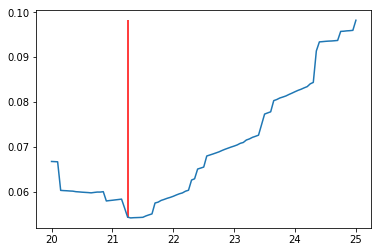

In [51]:
plot_1D_err(forward_params, 100, vline_x=inversed_model)

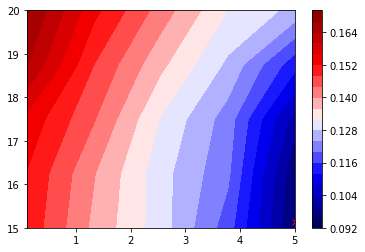

In [127]:
plot_2D_err(forward_params, [4, 4], 20, points=[[inversed_model[0]], [inversed_model[1]]])

Calculating rockphysics model...
Rockphysics model calculated!
Calculating PdPu-rays...
Calculating PdPu-reflections...
Calculating p-refractions...


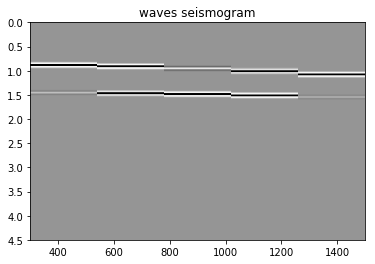

In [123]:
res = forward_with_trace_calcing(forward_params['model'], forward_params['x_rec'], 
                           dt=forward_params['dt'], 
                           trace_len=forward_params['trace_len'], 
                           wavetypes=forward_params['wavetypes'],
            display_stat=True, visualize_res=False,
                               visualize_seismograms=True
            )